### Importing Libraries

In [2]:
import pandas as pd
from pandas import MultiIndex, Int64Index
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.calibration import calibration_curve, CalibrationDisplay

In [3]:
import sys

In [4]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

### Importing Dataset

In [5]:
df = pd.read_csv("AssessmentDataSet.txt",sep="|")

In [6]:
df.shape

(300000, 128)

### Data Processing

 **Dropping colunms that have more than 50% NA values**

In [7]:
n = list(df.columns)
for i in n:
    if df[i].isna().sum() > len(df)//2:
        df.drop(columns=[i], inplace = True)

In [8]:
df.shape

(300000, 91)

 **Dropping colunms that have a constant value throughout the data**

In [9]:
n = list(df.columns)
for i in n:
    if 0 in list(df[i].value_counts().index):
        if df[i].value_counts()[0] == len(df):
            df.drop(columns=[i], inplace = True)


In [10]:
df.shape

(300000, 88)

### Data Visualisation

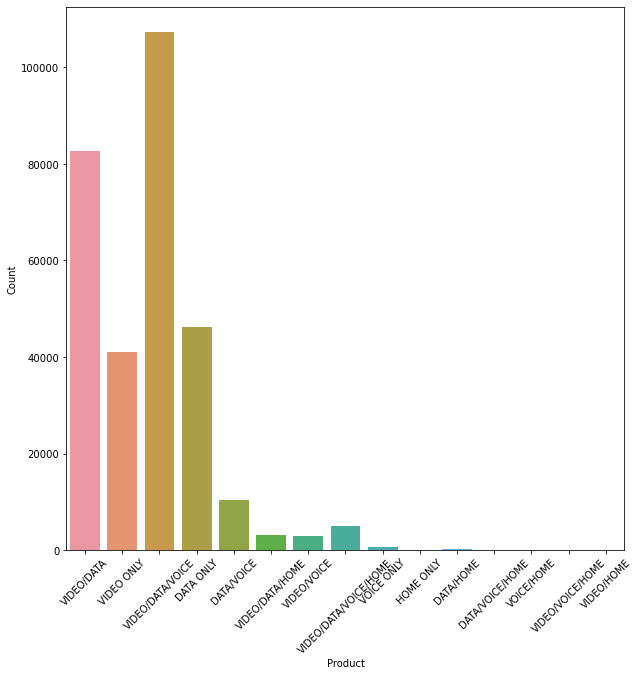

In [11]:
plt.figure(figsize=(10,10))
sns.countplot(x = 'product', data = df)
plt.xlabel('Product')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Count')
plt.show()

***For above plot we see the number of customers using each product. Next, for those products that have the least usegae, we will see next if customers are converting (up-sell/cross-sell) for these products.***

In [12]:
unique_products = list(df['product'].unique())
unique_products

['VIDEO/DATA',
 'VIDEO ONLY',
 'VIDEO/DATA/VOICE',
 'DATA ONLY',
 'DATA/VOICE',
 'VIDEO/DATA/HOME',
 'VIDEO/VOICE',
 'VIDEO/DATA/VOICE/HOME',
 'VOICE ONLY',
 'HOME ONLY',
 'DATA/HOME',
 'DATA/VOICE/HOME',
 'VOICE/HOME',
 'VIDEO/VOICE/HOME',
 'VIDEO/HOME']

In [13]:
list_lup = unique_products[-7:]
df_lup = df[df['product'].isin(list_lup)==True]

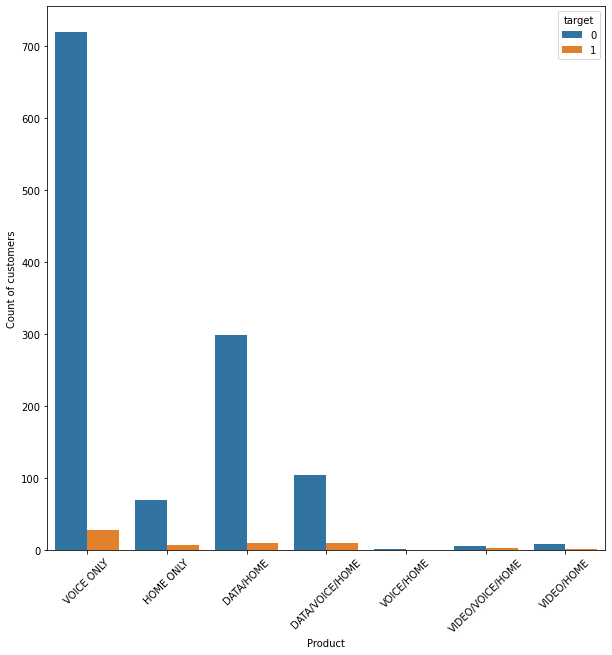

In [14]:
plt.figure(figsize=(10,10))
sns.countplot(x = 'product', data = df_lup, hue = 'target')
plt.xlabel('Product')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Count of customers')
plt.show()

***From the plot, we can observe that most of the customers who are using the above products, are less likely to sign up for additional product/services.***

***As a business, the company can work on identifying why there is a less usage of these products and how can the company devise strategies to increase the use of such products. One way of identifying the issue is by collective feedback from users or by sending surveys to customers to identify customer stress points***

### Feature Engineering

In [15]:
df['temp'] = df['AGE0_4'] + df['AGE10_14'] + df['AGE15_19'] + df['AGE20_24'] + df['AGE25_29'] + df['AGE30_34'] + df['AGE35_39'] + df['AGE40_44'] + df['AGE40_44'] + df['AGE45_49'] + df['AGE50_54'] + df['AGE55_59'] + df['AGE60_64'] + df['AGE65_69'] + df['AGE70_74'] + df['AGE75_79'] + df['AGE80_84'] + df['AGE85UP']

In [16]:
df['temp']

0         1.0183
1         0.9805
2         1.0004
3         1.0123
4         0.9699
           ...  
299995    0.9943
299996    1.0451
299997    0.9851
299998    1.0190
299999    0.9855
Name: temp, Length: 300000, dtype: float64

***Age feature is assumed to be the fraction of time the customer has spend on the content for each particular age group.  Since there are almost 40 age columns and few appear to be redundant so we created 4 buckets based on the age group. The buckets are as follows:***

 ***- Teen***
 
 ***- Young Adults***
 
 ***- Middle Aged Adults***
 
 ***- Old adults***

In [17]:
df.drop(columns = ['temp'], inplace = True)

In [18]:
df['Teen'] = df['AGE0_4'] + df['AGE10_14'] + df['AGE15_19'] 
df['Young_adults'] = df['AGE20_24'] + df['AGE25_29'] + df['AGE30_34'] + df['AGE35_39']
df['Middle_aged_adults'] = df['AGE40_44'] + df['AGE40_44'] + df['AGE45_49'] + df['AGE50_54'] + df['AGE55_59']
df['Old_adults'] = df['AGE60_64'] + df['AGE65_69'] + df['AGE70_74'] + df['AGE75_79'] + df['AGE80_84'] + df['AGE85UP']

In [19]:
# df.info()

**Dropping all other age columns as discussed above**

In [20]:
list_age = [x for x in df.columns if x[0] == 'A']
df.drop(columns = list_age, inplace = True)

In [21]:
df.columns

Index(['product', 'target', 'echan_full_court', 'echan_game_plan',
       'mls_direct_kick', 'nleague_plan', 'nhl_center_ice', 'rgu_bulk_voice',
       'svod_dchan_family_movies', 'use_self_service_all',
       'video_addon_family_tier', 'video_addon_music_choice', 'home_cam_id',
       'home_cam_od', 'home_oth_sens_co', 'home_oth_sens_cur',
       'home_oth_sens_fld', 'home_oth_sens_gls', 'home_peri_wifi', 'home_sik',
       'data_penetration_pct', 'prev_number_of_products', 'prev_rgu_voice',
       'bllng_amt', 'fcomp_internet', 'bulk_ind', 'video_penetration_pct',
       'hic_macs_count', 'x1_platform', 'cloud_dvr', 'video_days_on_books',
       'data_total_gb', 'offer_months_duration', 'mrm_rec_data_amt',
       'delinquent_90_balance_amt', 'prev_rgu_video', 'ucomp', 'prev_rgu_data',
       'ftcomp_internet', 'SPIX', 'vin_ind', 'infin_ind', 'tellop_ind',
       'DVD_LOVERS', 'DOG_LOVERS', 'PREMIUM', 'Teen', 'Young_adults',
       'Middle_aged_adults', 'Old_adults'],
      dtype='ob

**For each age bucket we introduced, we will check on how the upselling or crossselling of the product varies for different Age group content**

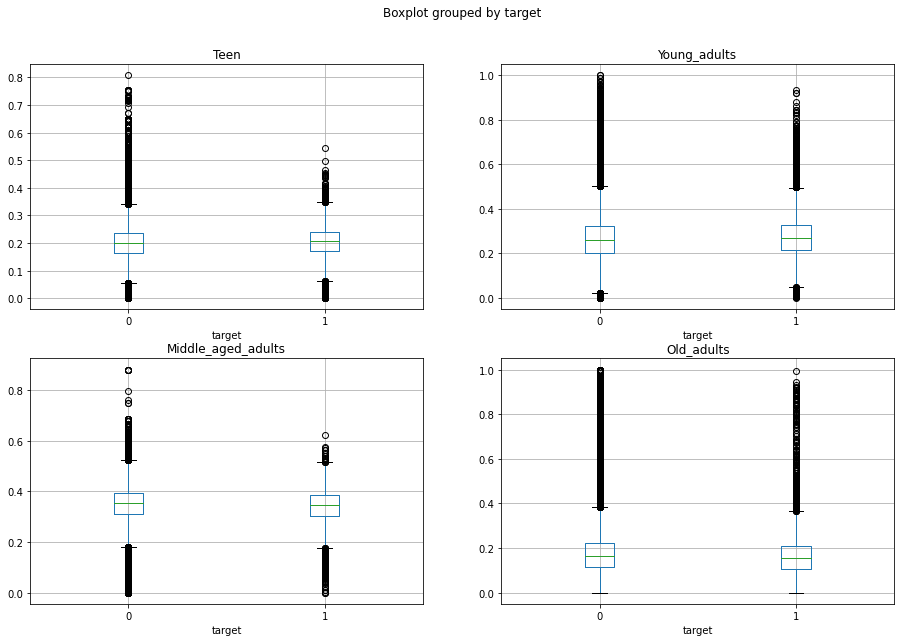

In [22]:
Age_list = ['Teen', 'Young_adults','Middle_aged_adults','Old_adults']
fig, axes = plt.subplots(2,2, figsize=(15,10)) # create figure and axes
for i,el in enumerate(Age_list):
    a = df.boxplot(el, by="target", ax=axes.flatten()[i])

plt.show()

**For each age bucket the boxplot will help us to understand if the duration of using the product 
has influence on upsell/Cross sell. However no significant conclusion can be made.**

In [23]:
l = df.columns
for i in l:
    print(df[i].value_counts())

VIDEO/DATA/VOICE         107215
VIDEO/DATA                82758
DATA ONLY                 46146
VIDEO ONLY                41050
DATA/VOICE                10448
VIDEO/DATA/VOICE/HOME      4992
VIDEO/DATA/HOME            3167
VIDEO/VOICE                2964
VOICE ONLY                  747
DATA/HOME                   308
DATA/VOICE/HOME             113
HOME ONLY                    75
VIDEO/HOME                    9
VIDEO/VOICE/HOME              7
VOICE/HOME                    1
Name: product, dtype: int64
0    292996
1      7004
Name: target, dtype: int64
0    299997
1         3
Name: echan_full_court, dtype: int64
0    299995
1         5
Name: echan_game_plan, dtype: int64
0    299988
1        12
Name: mls_direct_kick, dtype: int64
0    299872
1       128
Name: nleague_plan, dtype: int64
0    299875
1       125
Name: nhl_center_ice, dtype: int64
0    299965
1        35
Name: rgu_bulk_voice, dtype: int64
0    299042
1       958
Name: svod_dchan_family_movies, dtype: int64
0    299837
1   

**From value counts we can observe that 0 is the dominant label for for the aforementioned features so we 
considered dropping them**

In [24]:
remove_cols = ['echan_full_court', 'echan_game_plan', 'mls_direct_kick', 'rgu_bulk_voice', 'home_cam_id', 'home_cam_od', 'home_oth_sens_co', 'home_oth_sens_cur', 'home_oth_sens_fld', 'home_sik']
df.drop(columns = remove_cols, inplace = True)

### Continuous features exploration and imputation

In [25]:
continuous_feature = [feature for feature in df.columns if len(df[feature].unique())>15]
print("Continuous feature Count :{}".format(len(continuous_feature)))
print(continuous_feature)

Continuous feature Count :13
['data_penetration_pct', 'bllng_amt', 'video_penetration_pct', 'hic_macs_count', 'video_days_on_books', 'data_total_gb', 'offer_months_duration', 'mrm_rec_data_amt', 'delinquent_90_balance_amt', 'Teen', 'Young_adults', 'Middle_aged_adults', 'Old_adults']


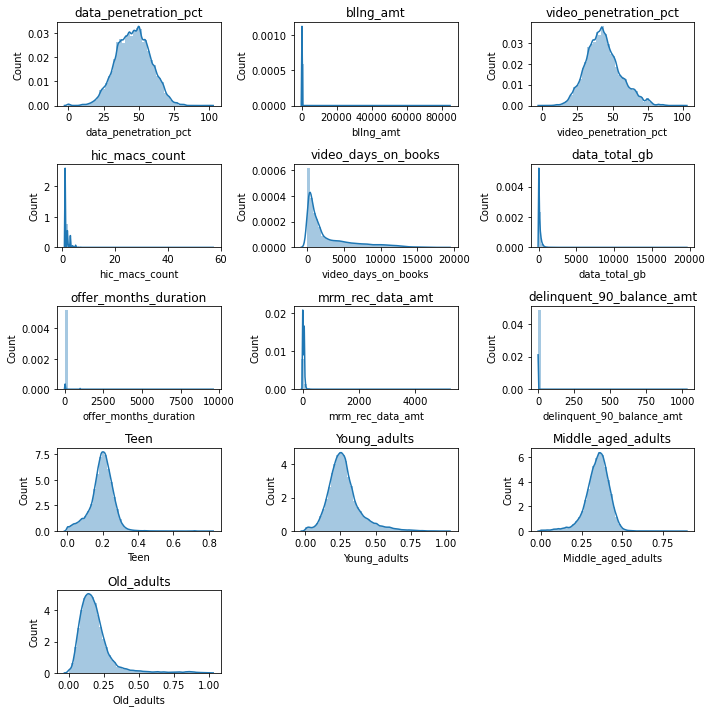

In [26]:
f = plt.figure(figsize = (10,10))
for i, feature in enumerate(continuous_feature):
    f.add_subplot(5, 3, i+1)
    sns.distplot(df[feature])
    plt.tight_layout()
    plt.ylabel("Count")
    plt.title(feature)
plt.show()
warnings.simplefilter(action='ignore', category=FutureWarning)


***As we can observe from the above plot - A lot of distrubutions are skewed. Some of these columns include - Billing amount, offer months duration, mrm_rec_data_amt etc, delinquent_90_balance_amt, data_total_gb etc***

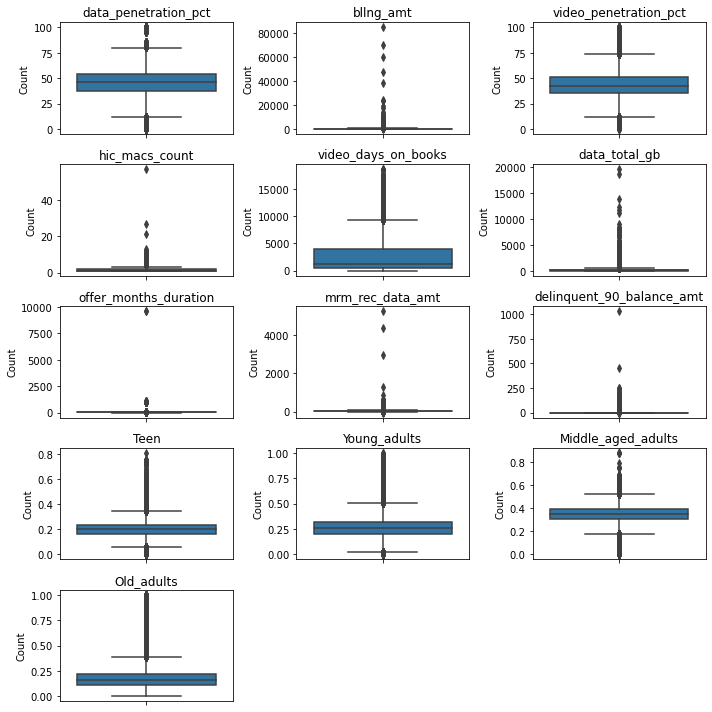

In [27]:
f = plt.figure(figsize = (10,10))
for i, feature in enumerate(continuous_feature):
    f.add_subplot(5, 3, i+1)
    sns.boxplot( y=df[feature])
    plt.tight_layout()
    plt.ylabel("Count")
    plt.title(feature)
plt.show()
warnings.simplefilter(action='ignore', category=FutureWarning)

***A lot of continuous features also tend to have a lot of outliers. Data imputation and outlier handling is handled below.***

### Missing values imputation for continuous features

In [28]:
df_new = df.groupby(by=['product']).agg({"data_total_gb":"mean"})
df_new.reset_index(inplace=True)

In [29]:
df_new

,product,data_total_gb
0,DATA ONLY,215.028478
1,DATA/HOME,246.121384
2,DATA/VOICE,175.752175
3,DATA/VOICE/HOME,185.642294
4,HOME ONLY,178.933000
5,VIDEO ONLY,23.142331
6,VIDEO/DATA,152.627127
7,VIDEO/DATA/HOME,156.244304
8,VIDEO/DATA/VOICE,119.614395
9,VIDEO/DATA/VOICE/HOME,155.996814


***For data_total_gb - Target encoding has been done. For target encoding - the mean of the total data used for that particular product has been done and has been imputed. The total gb column has more than 33 percent of the data as Nan. So we decided to impute it by taking the average data usage for that particular product.***

In [30]:
l1 = list(df_new.columns)
dict_ ={}

for index, row in df_new.iterrows():
    if row['product'] not in dict_.keys():
        dict_[row['product']] = row['data_total_gb']

In [31]:
dict_

{'DATA ONLY': 215.02847803054624,
 'DATA/HOME': 246.12138435374152,
 'DATA/VOICE': 175.7521747047244,
 'DATA/VOICE/HOME': 185.64229357798163,
 'HOME ONLY': 178.933,
 'VIDEO ONLY': 23.142331395348837,
 'VIDEO/DATA': 152.62712676361227,
 'VIDEO/DATA/HOME': 156.24430401529636,
 'VIDEO/DATA/VOICE': 119.61439457097633,
 'VIDEO/DATA/VOICE/HOME': 155.99681394880065,
 'VIDEO/HOME': 2.15125,
 'VIDEO/VOICE': 1.4057811280595955,
 'VIDEO/VOICE/HOME': 21.862285714285715,
 'VOICE ONLY': 2.115658064516129,
 'VOICE/HOME': 0.01}

In [32]:
def fun(row):
    if math.isnan(row['data_total_gb']):
        return dict_[row['product']]
    else:
        return row['data_total_gb']

In [33]:
df['data_total_gb'] = df.apply(lambda row:fun(row),axis=1)
df['data_total_gb'].isna().sum()

0

In [34]:
#df.info()

**For rest of the continuous features, we decided to divide the imputing strategy into median and zero based on the
data distibution and the meaning that feature entails**

In [35]:
impute_median = ['Teen', 'Young_adults', 'Middle_aged_adults', 'Old_adults', 'data_penetration_pct', 'hic_macs_count', 'video_days_on_books' ]
impute_zero = ['bllng_amt', 'video_penetration_pct', 'offer_months_duration','mrm_rec_data_amt','delinquent_90_balance_amt']

In [36]:
#df.info()

In [37]:
df[impute_zero] = df[impute_zero].fillna(value=0)

for i in impute_median:
    df[i] = df[i].fillna(value=df[i].median())


### Discrete features exploration and imputation

In [38]:
discrete_feature=[feature for feature in df.columns if len(df[feature].unique())<=15]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 27


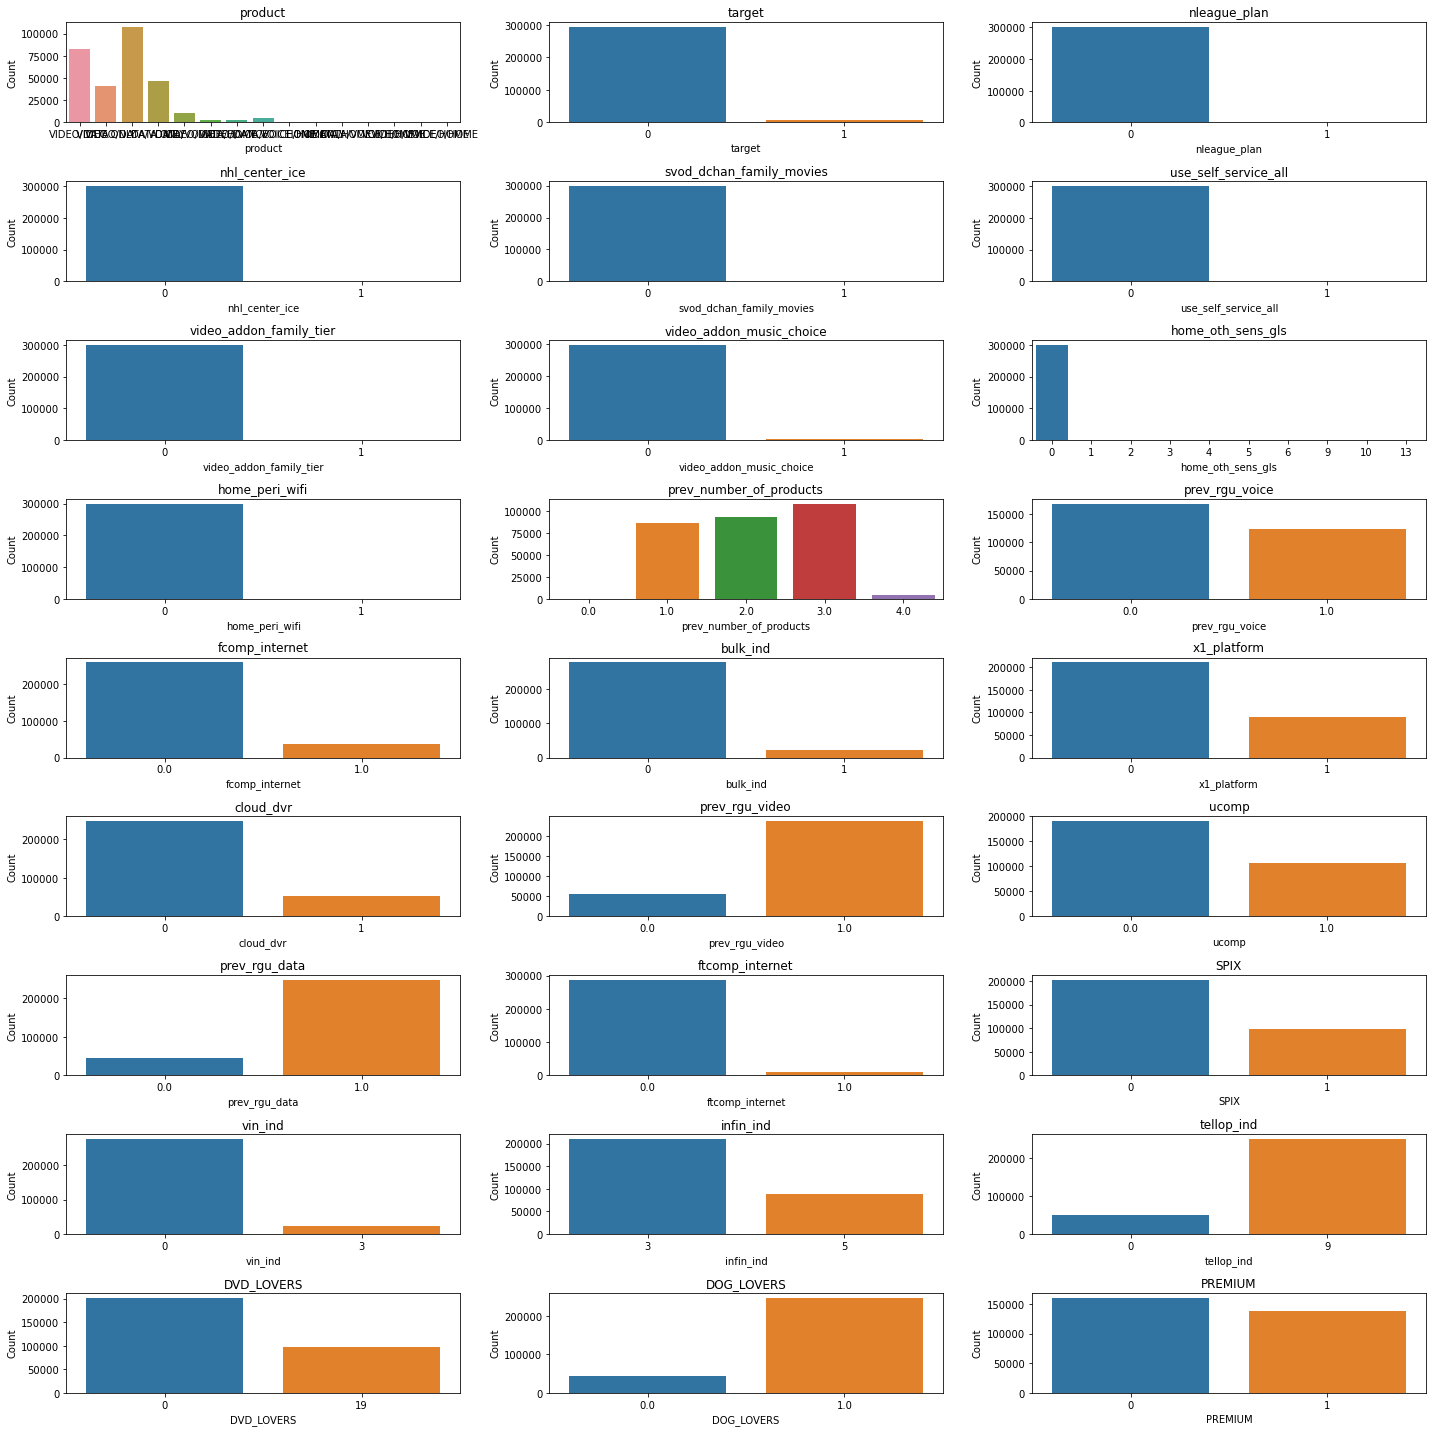

In [39]:
f = plt.figure(figsize = (20,20))
for i, feature in enumerate(discrete_feature):
    f.add_subplot(9, 3, i+1)
    sns.countplot(x = feature, data = df)
    plt.tight_layout()
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
plt.show()   
#warnings.simplefilter(action='ignore', category=FutureWarning)

### Missing values imputation for discrete features

In [40]:
list_discrete_zero = ['prev_number_of_products', 'prev_rgu_voice', 'prev_rgu_video', 'prev_rgu_data']
list_discrete_mode = ['fcomp_internet', 'ucomp', 'ftcomp_internet', 'DOG_LOVERS']

**For discrete features, we decided to divide the imputing strategy into mode and zero based on the
meaning that feature entails**

In [41]:
df[list_discrete_zero] = df[list_discrete_zero].fillna(value=0)

for i in list_discrete_mode:
    df[i].fillna(df[i].mode()[0], inplace = True)

In [42]:
df.isna().sum()

product                      0
target                       0
nleague_plan                 0
nhl_center_ice               0
svod_dchan_family_movies     0
use_self_service_all         0
video_addon_family_tier      0
video_addon_music_choice     0
home_oth_sens_gls            0
home_peri_wifi               0
data_penetration_pct         0
prev_number_of_products      0
prev_rgu_voice               0
bllng_amt                    0
fcomp_internet               0
bulk_ind                     0
video_penetration_pct        0
hic_macs_count               0
x1_platform                  0
cloud_dvr                    0
video_days_on_books          0
data_total_gb                0
offer_months_duration        0
mrm_rec_data_amt             0
delinquent_90_balance_amt    0
prev_rgu_video               0
ucomp                        0
prev_rgu_data                0
ftcomp_internet              0
SPIX                         0
vin_ind                      0
infin_ind                    0
tellop_i

**Dropping rows for which have negative values (small fraction of rows)**

In [43]:
df.drop(df[df['bllng_amt'] < 0].index, inplace = True)
df.drop(df[df['mrm_rec_data_amt'] < 0].index, inplace = True)
df.drop(df[df['video_days_on_books'] < 0].index, inplace = True)

### Plotting correlation heatmap

<AxesSubplot:>

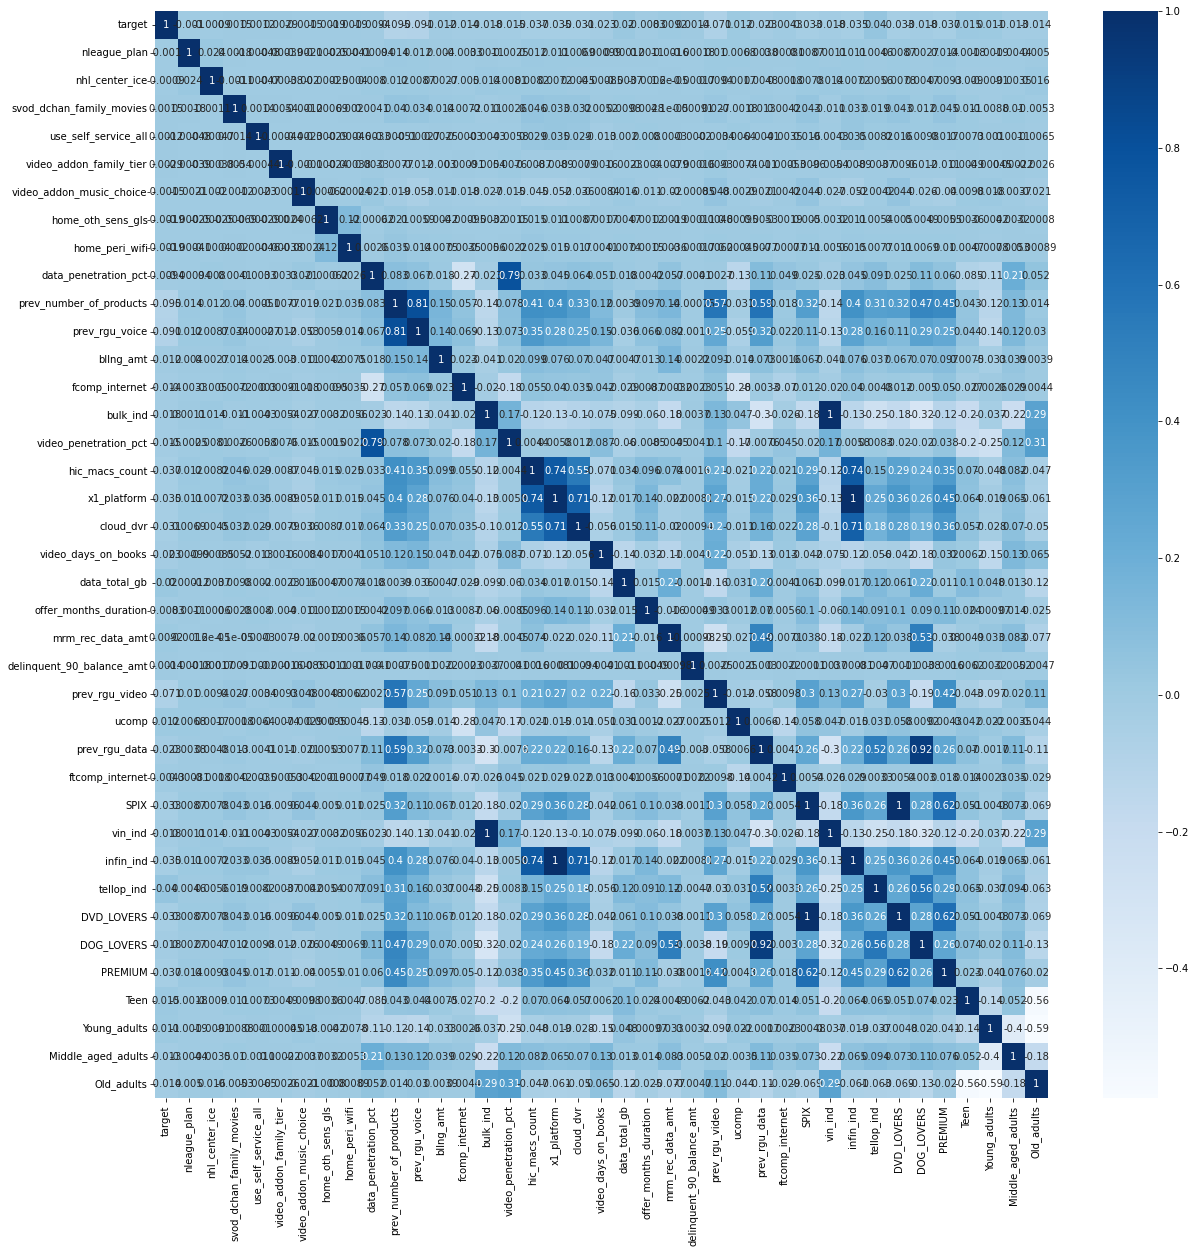

In [44]:
plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), cmap="Blues", annot=True)

**Dropping features that have a correlation greater than 0.90 to avoid the problem of multi collinearity**

In [45]:
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

In [46]:
to_drop

['vin_ind', 'infin_ind', 'DVD_LOVERS', 'DOG_LOVERS']

In [47]:
df.drop(columns=to_drop, inplace=True)

In [48]:
df.isna().sum()

product                      0
target                       0
nleague_plan                 0
nhl_center_ice               0
svod_dchan_family_movies     0
use_self_service_all         0
video_addon_family_tier      0
video_addon_music_choice     0
home_oth_sens_gls            0
home_peri_wifi               0
data_penetration_pct         0
prev_number_of_products      0
prev_rgu_voice               0
bllng_amt                    0
fcomp_internet               0
bulk_ind                     0
video_penetration_pct        0
hic_macs_count               0
x1_platform                  0
cloud_dvr                    0
video_days_on_books          0
data_total_gb                0
offer_months_duration        0
mrm_rec_data_amt             0
delinquent_90_balance_amt    0
prev_rgu_video               0
ucomp                        0
prev_rgu_data                0
ftcomp_internet              0
SPIX                         0
tellop_ind                   0
PREMIUM                      0
Teen    

In [49]:
#log_feature = ['bllng_amt','video_days_on_books', 'data_total_gb', 'offer_months_duration', 'mrm_rec_data_amt','delinquent_90_balance_amt']


In [50]:
#for feature in log_feature:
#    df[feature] = df[feature] + 0.01

In [51]:
#for feature in log_feature:
#    df[feature] = np.log(df[feature])

In [52]:
#f = plt.figure(figsize = (10,10))
#for i, feature in enumerate(log_feature):
#    f.add_subplot(3, 3, i+1)
#    sns.distplot(df[feature])
#    plt.tight_layout()
#    plt.ylabel("Count")
#    plt.title(feature)
#plt.show()
#warnings.simplefilter(action='ignore', category=FutureWarning)

**Here, I have tried multiple transformations like Log and Box_cox however, I noticed that for features like billing_amount and data_total_gb, the transformations returned negative values which did not make sense.**

### Detecting and removing outliers

In [53]:
df[continuous_feature].describe()

,data_penetration_pct,bllng_amt,video_penetration_pct,hic_macs_count,video_days_on_books,data_total_gb,offer_months_duration,mrm_rec_data_amt,delinquent_90_balance_amt,Teen,Young_adults,Middle_aged_adults,Old_adults
count,294637.000000,294637.000000,294637.000000,294637.000000,294637.000000,294637.000000,294637.000000,294637.000000,294637.000000,294637.000000,294637.000000,294637.000000,294637.000000
mean,46.177879,128.782528,43.383961,1.527385,2483.194402,132.487893,10.300583,41.321054,0.022476,0.195853,0.275494,0.348129,0.185544
std,12.103770,291.006510,12.192130,0.912593,3091.420613,212.691233,36.581818,32.445198,2.632349,0.064168,0.114677,0.073340,0.120628
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.610000,74.950000,35.100000,1.000000,567.000000,23.142331,0.000000,30.180000,0.000000,0.163800,0.204700,0.309700,0.113700
50%,46.280000,124.300000,42.470000,1.000000,1286.000000,57.784000,12.000000,40.300000,0.000000,0.200500,0.259900,0.354900,0.163200
75%,54.590000,173.290000,50.630000,2.000000,2912.000000,173.811000,12.000000,52.610000,0.000000,0.235000,0.322900,0.395600,0.221000
max,100.000000,84831.300000,100.000000,21.000000,18618.000000,19582.957000,9604.000000,5248.320000,1031.810000,0.754800,1.000000,0.882300,1.000100


In [54]:
outlier_list = ['bllng_amt','video_days_on_books', 'data_total_gb', 'offer_months_duration', 'mrm_rec_data_amt','delinquent_90_balance_amt']

for feature in outlier_list:
    q_hi  = df[feature].quantile(0.9998)
    index = df[(df[feature] >= q_hi)].index
    df.drop(index, inplace=True, axis = 0)

In [55]:
df.shape

(294098, 36)

In [56]:
df[outlier_list].describe()

,bllng_amt,video_days_on_books,data_total_gb,offer_months_duration,mrm_rec_data_amt,delinquent_90_balance_amt
count,294098.000000,294098.000000,294098.000000,294098.000000,294098.000000,294098.000000
mean,126.314492,2479.258856,131.205471,9.602279,41.185015,0.000003
std,74.195422,3079.950960,188.376625,8.814188,28.707101,0.000913
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.950000,567.000000,23.142331,0.000000,30.180000,0.000000
50%,124.200000,1286.000000,57.793000,12.000000,40.300000,0.000000
75%,173.070000,2912.000000,173.746250,12.000000,52.610000,0.000000
max,2640.020000,16951.000000,3783.713000,60.000000,363.100000,0.420000


### One hot encoding for categorical feature

In [57]:
# Categorical encoding
df_encoder = pd.get_dummies(df, columns=['product'])
df_encoder

,target,nleague_plan,nhl_center_ice,svod_dchan_family_movies,use_self_service_all,video_addon_family_tier,video_addon_music_choice,home_oth_sens_gls,home_peri_wifi,data_penetration_pct,...,product_VIDEO ONLY,product_VIDEO/DATA,product_VIDEO/DATA/HOME,product_VIDEO/DATA/VOICE,product_VIDEO/DATA/VOICE/HOME,product_VIDEO/HOME,product_VIDEO/VOICE,product_VIDEO/VOICE/HOME,product_VOICE ONLY,product_VOICE/HOME
0,0,0,0,0,0,0,0,0,0,33.41,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,36.70,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,36.83,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,61.66,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,32.73,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0,0,0,0,0,0,0,0,0,36.55,...,0,0,0,0,0,0,0,0,0,0
299996,0,0,0,0,0,0,0,0,0,40.07,...,0,1,0,0,0,0,0,0,0,0
299997,0,0,0,0,0,0,0,0,0,67.30,...,0,1,0,0,0,0,0,0,0,0
299998,0,0,0,0,0,0,0,0,0,37.67,...,1,0,0,0,0,0,0,0,0,0


In [58]:
X = df_encoder.drop(columns = 'target')
y = df_encoder['target']

### Splitting the Data between Train and test set

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

#### Applying robust scaler to scale features

In [60]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

***Here we have used Robust scaler because of the skewness in the data even after handling outliers.***

In [61]:
y_test = np.array(y_test)

###  Baseline logistic Model

**Our initial baseline model is logistic regression without any sampling. I have choosen this as my baseline since -**

**- It is intuitive and can easily be explained to stakeholders**

**- No need for performing hyper parameter tuning**

In [62]:
lr_1 = LogisticRegression(random_state = 42)
lr_1.fit(X_train_scaled, y_train)
y_lr_predict = lr_1.predict(X_test)

In [63]:
print(classification_report(y_test, y_lr_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     71789
           1       0.00      0.00      0.00      1736

    accuracy                           0.98     73525
   macro avg       0.49      0.50      0.49     73525
weighted avg       0.95      0.98      0.96     73525



### SMOTE 

**Our second Logistic regression model is one with upsampled data using SMOTE which randomly creates synthetic data for minority class and ensures we have equal percentage of data for both the classes**

In [64]:
smt = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smt.fit_resample(X_train_scaled, y_train)

In [65]:
y_train_smote.value_counts()

0    215365
1    215365
Name: target, dtype: int64

In [66]:
y_train.value_counts()

0    215365
1      5208
Name: target, dtype: int64

### Logistic Regression using oversampled Data

In [67]:
lr_2 = LogisticRegression(random_state = 42)
lr_2.fit(X_train_smote, y_train_smote)
y_lr_smote_predict = lr_2.predict(X_test)

In [68]:
print(classification_report(y_test, y_lr_smote_predict))

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     71789
           1       0.05      0.80      0.09      1736

    accuracy                           0.63     73525
   macro avg       0.52      0.71      0.43     73525
weighted avg       0.97      0.63      0.75     73525



In [69]:
roc_score_1 = roc_auc_score(y_test,lr_1.predict_proba(X_test)[:,1])
roc_score_2 = roc_auc_score(y_test,lr_2.predict_proba(X_test)[:,1])
print('AUROC score on normal and upsampled data are {} and {} respectively'.format(roc_score_1, roc_score_2))

AUROC score on normal and upsampled data are 0.7667872070756767 and 0.7707582418150272 respectively


***For our use case, since the cost of False negatives will cost the company more, therefore, Recall is a much more important metric for us incomparison to precision or accuracy. Since recall on upsampled data for label = 1 (minority class) is significantly high incomparison to the data without any sampling, here after, for all models I will be using upsampled data.***

### Random Forest

**Training a Random forest model on the upsampled data**

In [70]:
rf_1 = RandomForestClassifier(random_state = 42)
rf_1.fit(X_train_smote, y_train_smote)
y_rf_smote_predict = rf_1.predict(X_test)

In [71]:
print(classification_report(y_test, y_rf_smote_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     71789
           1       0.10      0.05      0.07      1736

    accuracy                           0.97     73525
   macro avg       0.54      0.52      0.53     73525
weighted avg       0.96      0.97      0.96     73525



***From the classification report, We observe that the precision, Recall values for the minority class that is label = 1 is close to 0. This means that the Random forest model is not able to correctly classify the minority class.***

**To see if there is a substantial improvement in the random forest model, I have performed hyper paramter tuning below -**

In [70]:
# Hyperparameter tuning
rf_2 = RandomForestClassifier(random_state = 42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 60, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 60, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [5, 11, 17, 23, 29, 35, 41, 47, 53, 60], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 16, 21, 27, 32, 38, 43, 49, 54, 60, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [71]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                   
random_rf = RandomizedSearchCV(estimator=rf_2, 
                           param_distributions=random_grid, 
                           n_iter=10,
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0
                                  )
# Fit the random search model
random_rf.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 16, 21, 27, 32, 38,
                                                      43, 49, 54, 60, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [5, 11, 17, 23, 29, 35,
                                                         41, 47, 53, 60]})

**Using the best set of hyper parameters to train our model**

In [ ]:
random_rf.best_params_


In [72]:
#{'n_estimators': 41,
# 'min_samples_split': 5,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': 49,
# 'bootstrap': False}

In [318]:
rf_tuned = RandomForestClassifier(**random_rf.best_params_, random_state = 42)
rf_tuned.fit(X_train_smote, y_train_smote)
y_rf_tuned_smote_predict = rf_tuned.predict(X_test)

In [319]:
print(classification_report(y_test, y_rf_tuned_smote_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     86180
           1       0.10      0.05      0.06      2084

    accuracy                           0.97     88264
   macro avg       0.54      0.52      0.52     88264
weighted avg       0.96      0.97      0.96     88264



***Even after tuning, our model performs poorly in classifying the minority class well.***

In [320]:
print(roc_auc_score(y_test,rf_tuned.predict_proba(X_test)[:,1]))

0.7464345705034636


### XGBoost

**Training a baseline XGboost classifier model on the upsampled trainig data**

In [77]:
xgbc_1 = XGBClassifier(random_state = 42)
xgbc_1.fit(X_train_smote, y_train_smote)
y_xgbc_predict = xgbc_1.predict(X_test)

[16:26:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [78]:
print(classification_report(y_test, y_xgbc_predict))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     71789
           1       0.07      0.24      0.11      1736

    accuracy                           0.91     73525
   macro avg       0.53      0.58      0.53     73525
weighted avg       0.96      0.91      0.93     73525



***From the above classification report,we can see that XGB does a better job in classifying the minority class correctly in comparison to Random forest classifier. However, logistic regression still outperforms the XGB classifier.***


In [73]:
print(roc_auc_score(y_test,xgbc_1.predict_proba(X_test)[:,1]))

0.7444758667120548


**To see if we can further improve the performance of XGB Classifier, I have performed hyper paramter tuning below -**

In [79]:
# Hyperparameter tuning
xgbc_2 = XGBClassifier(random_state = 42)
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(1,40,6),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,3)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,8)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-2, 0.1, 1, 10, 100]
                   }

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
                   
random_xgb = RandomizedSearchCV(estimator=xgbc_2, 
                           param_distributions=param_grid, 
                           n_iter=5,
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0
                                  )

In [80]:
random_xgb.fit(X_train_smote, y_train_smote)

/Users/vedant/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/vedant/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/vedant/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/vedant/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future versio

/Users/vedant/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:39:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:30:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:30:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:30:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           valida

In [169]:
random_xgb.best_params_

{'reg_lambda': 0.1,
 'reg_alpha': 0.1,
 'max_depth': 19,
 'learning_rate': 1,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [ ]:
#{'reg_lambda': 0.1,
# 'reg_alpha': 0.1,
# 'max_depth': 19,
# 'learning_rate': 1,
# 'gamma': 0.1,
# 'colsample_bytree': 0.7}

In [170]:
xgbc_tuned = XGBClassifier(**random_xgb.best_params_, random_state = 42)
xgbc_tuned.fit(X_train_smote, y_train_smote)
y_xgbc_tuned_smote_predict = rf_tuned.predict(X_test)

[03:35:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [171]:
print(classification_report(y_test, y_xgbc_tuned_smote_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     86180
           1       0.08      0.04      0.05      2084

    accuracy                           0.97     88264
   macro avg       0.53      0.51      0.52     88264
weighted avg       0.96      0.97      0.96     88264



***Even after tuning, our model performs poorly in classifying the minority class well.***

In [172]:
print(roc_auc_score(y_test,rf_tuned.predict_proba(X_test)[:,1]))

0.743195306302169


***Based on the multiple modeling approaches that were used, I will go ahead with Logistic regression trained on upsampled data for this problem statement. This is because -***

***- Better Recall value in comparison to other models tested***

***- Intuitive model with ease of explanibility***

### Model interpretibility - Shapley values and plots

**For model interpretibility, I have plotted the SHAP values and graphs below to understand the marginal contribution
of each feature for the XGBoost model**

In [ ]:
# !pip install shap

In [84]:
import shap
explainer = shap.TreeExplainer(xgbc_1)
shap_values = explainer.shap_values(X_train_smote)
shap_values_ebm = explainer(X_train_smote)
shap.initjs()

In [86]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])


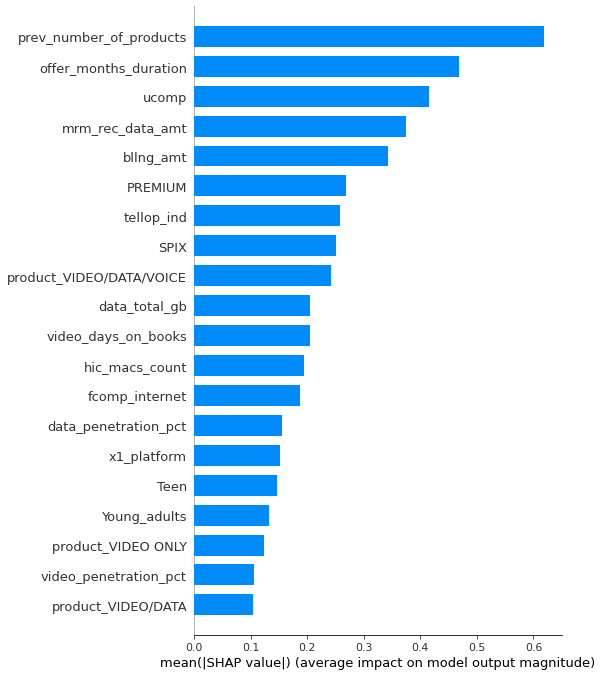

In [87]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [89]:
# shap.plots.beeswarm(shap_values)

In [91]:
# shap.plots.waterfall(shap_values)

***Based on the feature importance graph above, we see feature "previous_number_of_products" has the highest impact on the target variable. It could mean that if a customer is using multiple products simultaneously, then we can say that customer is loyal to the company and is most likely going to up-sell/cross-sell if a new product gets introducted.***

***Similarly, "ucomp" is another top feature that has a high impact on target variable. This means that presence of a competitive service provider in the area impacts customer's decision to up-sell/cross-sell to addition products. One interpretation could be, If the service providers is an area is not doing a good job then customer's are more likely to up-sell/cross-sell with additional products that Comcast provides. Whereas, if the service provider's product is competitive to Comcast's offerings, then there is a chance that customer will not up-sell/cross-sell.***

***Additional features that influence a customer's decisions are - Offer_months_duration,hic_macs_count, fcomp_internet.***

### Model caliberation

**Since our dataset is imbalanced, however, our models were trained on balanced data, therefore it is essential
to look at caliberation curves before concluding which model is performing the best amongst the others. Here, we will
plot the caliberation curves for all the three models -**

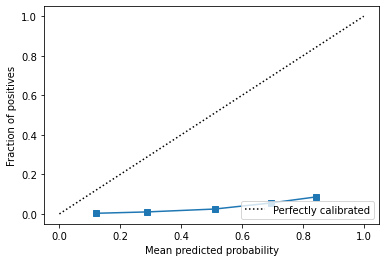

In [323]:
# Logistic Regression
y_prob = lr_2.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

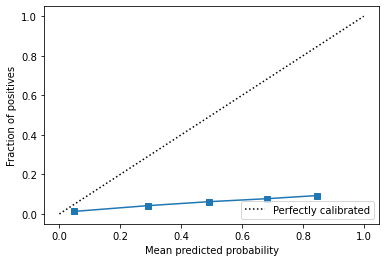

In [324]:
# XGB Classifier Regression
y_prob = xgbc_1.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

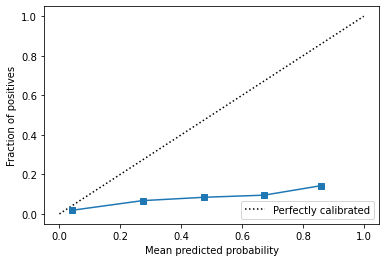

In [325]:
# Random forest Classifier Regression
y_prob = rf_tuned.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

***As visible in all of the above graphs, none of the models are well caliberated, that is, there is a difference between the true value of the lable and the predicted probability that the model has computed for the label. To improve this -***

***1. We can perform isotonic regression (that is fit a logistic regression model on top of our trained models, to make sure our predicted probabilities are as close as the true label).***
   
***2. Collect more samples of the minority class so that the model is able to learn the variations in dataset for 
   the minority class***
